# Vep assessment breakdown

Analysis done to check the contribution of each vep assessment score for lead variants in credible sets

## Methods

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns


In [3]:
# Set default figure theme
sns.set_theme(
    context="paper",
    palette=sns.set_palette(sns.color_palette("coolwarm")),
    style="whitegrid",
)


def adjust_study_type(study_type: pl.Expr) -> pl.Expr:
    """Adjust study type based on qtl distance type."""
    qtl_distance_type = (
        pl.when(pl.col("isTransQtl"))
        .then(pl.lit("trans"))
        .when(~pl.col("isTransQtl"))
        .then(pl.lit("cis"))
        .otherwise(pl.lit(None))
    )
    adjusted_study_type = (
        pl.when(study_type == "pqtl")
        .then(pl.concat_str(qtl_distance_type, study_type, separator="-"))
        .otherwise(study_type)
        .alias("studyType")
    )
    return adjusted_study_type


class VepScoringGroup:
    def __init__(self, score: str, label: str):
        assert isinstance(score, (int, float)), "Score must be a number"
        assert isinstance(label, str), "Label must be a string"
        self.score = score
        self.label = label

    def __gt__(self, other: VepScoringGroup) -> bool:
        return self.score > other.score

    def __lt__(self, other: VepScoringGroup) -> bool:
        return self.score < other.score

    def __eq__(self, other: VepScoringGroup) -> bool:
        return self.score == other.score


def classify_by_vep_score(effect: pl.Expr, scores: list[VepScoringGroup] | None = None) -> pl.Expr:
    """Classify the vep score by given scores."""
    if not scores:
        scores = [
            VepScoringGroup(score=0.0, label="very low"),
            VepScoringGroup(score=0.1, label="low"),
            VepScoringGroup(score=0.33, label="medium"),
            VepScoringGroup(score=0.66, label="high"),
            VepScoringGroup(score=1.0, label="very high"),
        ]
    expr = pl.when(False).then(None)
    groups = sorted(scores, reverse=True)
    for group in groups:
        expr = expr.when(effect.struct.field("normalisedScore") >= group.score).then(pl.lit(group.label))
    expr = expr.otherwise(pl.lit(None)).alias("vepScoreClass")
    return expr


## Dataset loading

In [4]:
dataset = pl.read_parquet("../../data/rescaled-betas.parquet")


In [5]:
df = dataset.select(
    pl.col("vepEffect").struct.unnest(),
    classify_by_vep_score(pl.col("vepEffect")),
    adjust_study_type(pl.col("studyType")),
    pl.col("finemappingMethod"),
)


In [15]:
data = (
    df.with_columns(cat=pl.concat_str(pl.col("studyType"), separator=" - "), ones=pl.lit(1))
    .group_by("cat", "assessment")
    .agg(pl.sum("ones"), pl.first("normalisedScore"), pl.first("vepScoreClass"))
    .sort("ones")
    .pivot(
        on=["cat"],
        index=["assessment", "normalisedScore", "vepScoreClass"],
        values=["ones"],
        aggregate_function="sum",
    )
    # .fill_null(0)
).sort("normalisedScore", "assessment", descending=True, maintain_order=True)

ordered_cols = sorted(df["studyType"].unique().to_list())
new_names = [f"% {c}" for c in ordered_cols]
print(ordered_cols)
percent = [(pl.col(old) / pl.sum(old) * pl.lit(100)).alias(new) for old, new in zip(ordered_cols, new_names)]
ordered_groups = ["very low", "low", "medium", "high", "very high"]
data = data.select("assessment", *ordered_cols, *percent, "normalisedScore", "vepScoreClass").sort("normalisedScore")
data = data.to_pandas()
assessment_order = data["assessment"]
data


['cis-pqtl', 'eqtl', 'gwas', 'sceqtl', 'sqtl', 'trans-pqtl', 'tuqtl']


,assessment,cis-pqtl,eqtl,gwas,sceqtl,sqtl,trans-pqtl,tuqtl,% cis-pqtl,% eqtl,% gwas,% sceqtl,% sqtl,% trans-pqtl,% tuqtl,normalisedScore,vepScoreClass
0,coding_sequence_variant,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.000074,NaN,NaN,NaN,NaN,NaN,0.00,very low
1,downstream_gene_variant,4.0,23,67.0,1.0,6.0,4.0,1.0,0.024911,0.001704,0.011623,0.001896,0.002684,0.022624,0.000260,0.00,very low
2,intergenic_variant,NaN,1,29.0,NaN,NaN,NaN,NaN,NaN,0.000074,0.005031,NaN,NaN,NaN,NaN,0.00,very low
3,mature_miRNA_variant,1.0,89,45.0,1.0,5.0,3.0,33.0,0.006228,0.006594,0.007807,0.001896,0.002237,0.016968,0.008573,0.00,very low
4,non_coding_transcript_exon_variant,304.0,49858,12565.0,1875.0,5886.0,240.0,8324.0,1.893255,3.694006,2.179830,3.554772,2.633475,1.357466,2.162432,0.00,very low
5,upstream_gene_variant,4442.0,282036,150521.0,12256.0,33399.0,4162.0,69366.0,27.663947,20.896199,26.113032,23.235885,14.943156,23.540724,18.020092,0.00,very low
6,3_prime_UTR_variant,431.0,70710,17249.0,1826.0,7102.0,473.0,27002.0,2.684188,5.238942,2.992431,3.461874,3.177529,2.675339,7.014654,0.10,low
7,5_prime_UTR_variant,120.0,23145,3010.0,759.0,3064.0,129.0,10741.0,0.747338,1.714826,0.522188,1.438972,1.370874,0.729638,2.790327,0.10,low
8,intron_variant,8913.0,845630,345472.0,34284.0,151604.0,9676.0,236298.0,55.508501,62.653182,59.933972,64.998294,67.829643,54.728507,61.386149,0.10,low
9,splice_donor_region_variant,15.0,3174,431.0,75.0,901.0,22.0,1120.0,0.093417,0.235163,0.074772,0.142191,0.403119,0.124434,0.290957,0.33,medium


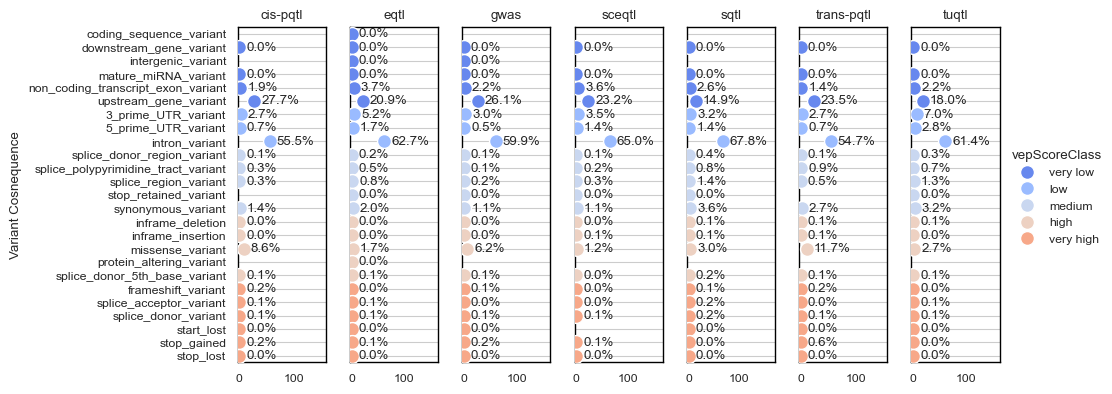

In [17]:
g = sns.PairGrid(
    data,
    y_vars=["assessment"],
    x_vars=new_names,
    hue="vepScoreClass",
    aspect=0.3,
    height=4,
    dropna=True,
)
g.map(
    sns.stripplot,
    size=10,
    orient="h",
    jitter=True,
    palette="flare_r",
    linewidth=1,
    edgecolor="w",
    order=assessment_order,
)
g.set(ylabel="Variant Cosnequence")
# g.map(plt.pie(x))

titles = ordered_cols

for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set_xlabel(None)

    for collection in ax.collections:
        offsets = collection.get_offsets()
        for x, y in offsets:
            x_lim_1 = ax.get_xlim()[1]
            ax.annotate(
                f"{round(x, 1):.1f}%", xy=(x, y), xytext=(5, 0), textcoords="offset points", ha="left", va="center"
            )
    x_lim = ax.get_xlim()
    ax.set_xlim((x_lim[0], x_lim[1] + 100))

sns.despine(left=True, bottom=True)

for ax in g.axes.flatten():  # Loop directly on the flattened axes
    for _, spine in ax.spines.items():
        spine.set_visible(True)  # You have to first turn them on
        spine.set_color("black")
        spine.set_linewidth(1)
    ax.set_facecolor((0, 0, 0, 0))  # Set the axes background to be transparent


g.add_legend()

g.figure.patch.set_alpha(0)  # Set the figure background to be transparent
plt.show()
